In [19]:
import re
import random
import pandas as pd
import hashlib

In [20]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [21]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
PP365,124.270610,62.135305,2
PnP Powershell,148.420866,3.905812,38
Vocab,267.924140,24.356740,11
Audit Report Tracker (Sharepoint List),286.283999,17.892750,16
Azure Functions + Visual Studio,287.204687,20.514621,14
Taxes,358.455855,89.613964,4
OData,434.309572,31.022112,14
Debugging in VS Code,457.093244,19.873619,23
Azure AI Search,508.431364,36.316526,14
Powershell Modules,795.355679,26.511856,30


# Histogram

46332.25


<Axes: >

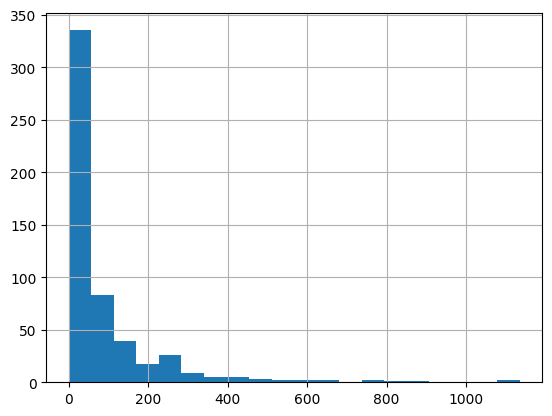

In [22]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [23]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [24]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [25]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [26]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [27]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [28]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [30]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [31]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age Max

In [32]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 534


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
233,DNS,Group Policy Management for DNS\nUsing Group P...,ba1c8eeab73c15d658c317408f3c563f,-1134.515783,158.672659,-1134.515783,2856.107867,0.832464,0,0
232,DNS,Remove-DnsServerZone (PowerShell Cmdlet)\nA Po...,7a23a1aa4e9048f544f71ac086eaf184,-159.266125,158.672659,-1134.515783,2856.107867,0.832464,3,0
47,DNS,Active Directory-Integrated Zones\nDNS zones t...,41626b12a531ad6eb31ce82e13597942,-82.784968,158.672659,-1134.515783,2856.107867,0.832464,6,0
237,DNS,Conditional Forwarding\nA DNS configuration th...,307c5eb4cae4981eb5b4f0a6f1646b77,-48.279386,158.672659,-1134.515783,2856.107867,0.832464,9,0
235,DNS,DNS Manager\nA graphical administrative tool i...,ec33258f7f93c84f4574e71178066c9b,-26.772064,158.672659,-1134.515783,2856.107867,0.832464,12,0
413,DNS,DNS Policies\nA feature in Windows DNS Server ...,e14697957838c2353f653a56dac9ac16,-22.104996,158.672659,-1134.515783,2856.107867,0.832464,15,0
6,IW Migration,Stored Procedures and Triggers\nDatabase compo...,0520ce3d951c0fab568ae40aa63fcd63,-1128.559301,192.655384,-1128.559301,4238.418453,0.614391,0,0
9,IW Migration,Linked Table Manager (in Access)\nA feature in...,5c59183063f46f48886078e49c5fa8ff,-307.452074,192.655384,-1128.559301,4238.418453,0.614391,3,0
196,IW Migration,Functions (User-Defined Functions) (SQL Server...,668adfc065c3a61f0b42c4c8a10594dc,-264.147452,192.655384,-1128.559301,4238.418453,0.614391,6,0
381,IW Migration,Check Constraints and Computed Columns (SQL Se...,d96d6d64c901f0c15fbd29df26d25d0a,-111.140806,192.655384,-1128.559301,4238.418453,0.614391,9,0


## Age Mean

In [33]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [34]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [35]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
233,DNS,Group Policy Management for DNS\nUsing Group P...,ba1c8eeab73c15d658c317408f3c563f,-1134.515783,158.672659,-1134.515783,2856.107867,0.832464,0,0
232,DNS,Remove-DnsServerZone (PowerShell Cmdlet)\nA Po...,7a23a1aa4e9048f544f71ac086eaf184,-159.266125,158.672659,-1134.515783,2856.107867,0.832464,3,0
47,DNS,Active Directory-Integrated Zones\nDNS zones t...,41626b12a531ad6eb31ce82e13597942,-82.784968,158.672659,-1134.515783,2856.107867,0.832464,6,0
237,DNS,Conditional Forwarding\nA DNS configuration th...,307c5eb4cae4981eb5b4f0a6f1646b77,-48.279386,158.672659,-1134.515783,2856.107867,0.832464,9,0
235,DNS,DNS Manager\nA graphical administrative tool i...,ec33258f7f93c84f4574e71178066c9b,-26.772064,158.672659,-1134.515783,2856.107867,0.832464,12,0
413,DNS,DNS Policies\nA feature in Windows DNS Server ...,e14697957838c2353f653a56dac9ac16,-22.104996,158.672659,-1134.515783,2856.107867,0.832464,15,0
6,IW Migration,Stored Procedures and Triggers\nDatabase compo...,0520ce3d951c0fab568ae40aa63fcd63,-1128.559301,192.655384,-1128.559301,4238.418453,0.614391,0,0
9,IW Migration,Linked Table Manager (in Access)\nA feature in...,5c59183063f46f48886078e49c5fa8ff,-307.452074,192.655384,-1128.559301,4238.418453,0.614391,3,0
196,IW Migration,Functions (User-Defined Functions) (SQL Server...,668adfc065c3a61f0b42c4c8a10594dc,-264.147452,192.655384,-1128.559301,4238.418453,0.614391,6,0
381,IW Migration,Check Constraints and Computed Columns (SQL Se...,d96d6d64c901f0c15fbd29df26d25d0a,-111.140806,192.655384,-1128.559301,4238.418453,0.614391,9,0


In [36]:
existing_cards.head(10)['age'].sum()

-3285.0229540710407